# Initialize Packages

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import cv2
from torch.utils.data import random_split
import numpy as np
import gc
torch.cuda.empty_cache()
gc.collect()
import torch
from torch import nn
from tqdm import tqdm
from skimage.registration import phase_cross_correlation

In [2]:
def np_to_torch(np_array):
    '''
    Here i am converting numpy array into torch
    '''
    return torch.from_numpy(np_array).float()

def torch_to_np(torch_array):
    '''
    Here i take torch tensor array, detach it from computational graph, make sure that it is on cpu as a numpy array
    '''
    return np.squeeze(torch_array.detach().cpu().numpy())

def check_if_dir_existed(dir_name, create=False):
	'''
    Fast check if directory exist
    '''
	if not os.path.exists(dir_name):
		print(f'folder \t\t: {dir_name} is not available')
		if create:
			os.mkdir(dir_name)
			print(f'folder \t\t: {dir_name} created')	
	else:
		print(f'folder \t\t: {dir_name} is available')

def trunc(a, x):
    '''
    Truncate value
    '''
    int1 = int(a * (10**x))/(10**x)
    return float(int1)

device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Output Folder

In [3]:
output_folder = './output'

check_if_dir_existed(output_folder, True)	
# output folder for Sourced Images (original, not-processed)
src_output = f'{output_folder}/src'
# output folder for Destination Images (Created by simple Sub-Pixel Interpolation)
dst_output = f'{output_folder}/dst'
# output folder for Images Generated with simple CNN model
ml_output = f'{output_folder}/ml'
check_if_dir_existed(src_output, True)
check_if_dir_existed(dst_output, True)	
check_if_dir_existed(ml_output, True)		


folder 		: ./output is not available
folder 		: ./output created
folder 		: ./output/src is not available
folder 		: ./output/src created
folder 		: ./output/dst is not available
folder 		: ./output/dst created
folder 		: ./output/ml is not available
folder 		: ./output/ml created


# Prepare Dataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, image_dir) -> None:
        super(CustomDataset, self).__init__()
        self.data = []

        for folder_name in os.listdir(image_dir):
            if folder_name=="src":
                for image_name in os.listdir(f"{image_dir}/{folder_name}"):
                    if (image_name.endswith(".png")):
                        src_img_name = f"{image_dir}/{folder_name}/{image_name}"
                        dst_img_name = f"{image_dir}/dst/s_{image_name}"
                        self.data.append([src_img_name, dst_img_name])

    def __len__(self) -> int:
        return len(self.data)

    def load_image(self, index: int):
        src_fname, dst_fname = self.data[index]
        src_image = cv2.imread(src_fname, cv2.COLOR_BGR2GRAY)
        dst_image = cv2.imread(dst_fname, cv2.COLOR_BGR2GRAY)
        return src_image, dst_image

    def __getitem__(self, index: int):
        src_image, dst_image = self.load_image(index)
        return np_to_torch(src_image), np_to_torch(dst_image)
input_dataset = './dataset/'    
dataset = CustomDataset(image_dir='./dataset/')

# Split Dataset. 80 pairs of images to train, 19 images to test

In [5]:
train_data, test_data = random_split(dataset, [80, 19])
print("The length of Train data is:",len(train_data))
print("The length of Test data is:",len(test_data))

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=8)
#print(f"\tNum. of batches: \t\t{len(train_loader)}")
#print(f"\tNum. of total examples: \t{len(train_loader.dataset)}")
#check train data types
#img0, img1 = next(iter(train_data))
#print(torch.min(img0), torch.max(img0), img0.dtype)

The length of Train data is: 80
The length of Test data is: 19


# Fast Check

Text(0.5, 1.0, 'Destination image generated with Classical Interpolation Method')

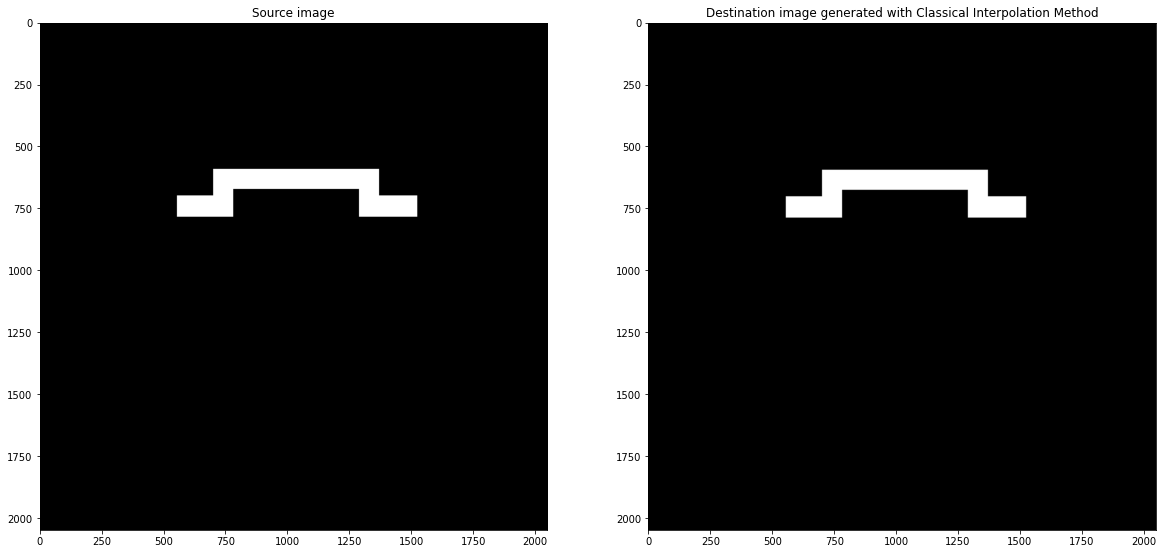

In [6]:
src_image, dest_image = train_data[0][0], train_data[0][1]

fi1, axs1 = plt.subplots(1, 2, figsize=(20, 10))
axs1[0].imshow(src_image, cmap='gray'); 
axs1[0].set_title('Source image')
axs1[1].imshow(dest_image, cmap='gray'); 
axs1[1].set_title('Destination image generated with Classical Interpolation Method')


# CNN Model. Image input / Image output

In [35]:
torch.cuda.empty_cache()
gc.collect()
class CNN(nn.Module):
    def __init__(self, num_channels):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1,            num_channels, 3, padding=1), 
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1), 
            nn.PReLU(),
            nn.Conv2d(num_channels, num_channels, 3, padding=1), 
            nn.PReLU(),
            nn.Conv2d(num_channels, 1,            3, padding=1), 
            nn.PReLU()
        )
        # No flatten layers
    def forward(self, x):
        x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
        return x
cnn = CNN(1).to(device)

# Criterion and Optimizer

In [36]:
loss_fun  = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# Train CNN to do sub-pixel offset (from src to dest) 

0 in 200: 100%|██████████| 80/80 [00:03<00:00, 21.56it/s]


Epoch 0 in 200, Loss 2478.0810546875


20 in 200: 100%|██████████| 80/80 [00:03<00:00, 21.01it/s]


Epoch 20 in 200, Loss 27.515323638916016


40 in 200: 100%|██████████| 80/80 [00:03<00:00, 21.08it/s]


Epoch 40 in 200, Loss 1.4627554416656494


60 in 200: 100%|██████████| 80/80 [00:03<00:00, 21.32it/s]


Epoch 60 in 200, Loss 0.7155769467353821


80 in 200: 100%|██████████| 80/80 [00:03<00:00, 20.89it/s]


Epoch 80 in 200, Loss 0.5695127248764038


100 in 200: 100%|██████████| 80/80 [00:04<00:00, 19.49it/s]


Epoch 100 in 200, Loss 0.5013250112533569


120 in 200: 100%|██████████| 80/80 [00:03<00:00, 20.64it/s]


Epoch 120 in 200, Loss 0.4435335397720337


140 in 200: 100%|██████████| 80/80 [00:03<00:00, 20.57it/s]


Epoch 140 in 200, Loss 0.39967721700668335


160 in 200: 100%|██████████| 80/80 [00:03<00:00, 20.93it/s]


Epoch 160 in 200, Loss 0.36432623863220215


180 in 200: 100%|██████████| 80/80 [00:04<00:00, 19.76it/s]


Epoch 180 in 200, Loss 0.3478076457977295


199 in 200: 100%|██████████| 80/80 [00:03<00:00, 21.06it/s]


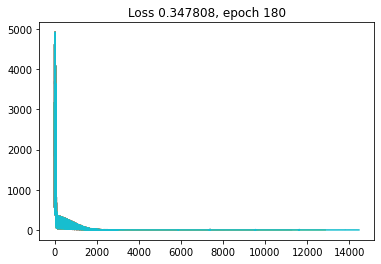

In [37]:
epochs = 200
train_loss = []
fig = plt.figure()
ax0 = fig.add_subplot(1,1,1)

for epoch in range(epochs):
    correct=0
    for i in tqdm(range(len(train_data)),desc = f'{epoch} in {epochs}'):
        src_image, dst_image = train_data[i]
        src_image  =src_image.to(device)
        dst_image  =dst_image.to(device)
        output = cnn(src_image).to(device)
        loss = loss_fun(output, dst_image)
        optimizer.zero_grad()           
        loss.backward()       
        optimizer.step()                
        train_loss.append(loss.item())
        del src_image
        del dst_image
        
    if epoch % 20 == 0:
        print(f"Epoch {epoch} in {epochs}, Loss {loss.item()}")
        ax0.plot(train_loss[19:-1])
        ax0.set_title('Loss %f, epoch %d' % (train_loss[-1],epoch));   

torch.save({'state_dict': cnn.state_dict()}, "shift.bin")

Test

In [8]:
cnn.to('cpu')
detected_shift = []
S0, S1, S2, MSE = [], [], [], []
with torch.no_grad():
    test_loss = 0
    i = 0
    for i in tqdm(range(len(test_data)),desc = 'tqdm() Progress Bar'):
        src_image, dst_image = test_data[i]
        src_image  =src_image.to("cpu")
        dst_image  =dst_image.to("cpu")
        output = cnn(src_image)
        loss = loss_fun(output, dst_image)
        test_loss += loss.item()
        cv2.imwrite(f'{src_output}/{i}.png', torch_to_np(src_image))
        cv2.imwrite(f'{dst_output}/s_{i}.png', torch_to_np(dst_image))
        cv2.imwrite(f'{ml_output}/ml_{i}.png', torch_to_np(output))
        s0, e, dif = phase_cross_correlation(torch_to_np(src_image), torch_to_np(dst_image), upsample_factor=1000)
        mse0 = np.mean((torch_to_np(dst_image) - torch_to_np(output)) ** 2, dtype=np.float64)
        s1, e, dif = phase_cross_correlation(torch_to_np(src_image), torch_to_np(output), upsample_factor=1000)
        s2, e, dif = phase_cross_correlation(torch_to_np(dst_image), torch_to_np(output), upsample_factor=1000)
        S0.append(np.mean(s0))
        S1.append(np.mean(s1))
        S2.append(np.mean(s2))
        MSE.append(np.mean(mse0))
        i = i +1

tqdm() Progress Bar: 100%|██████████| 19/19 [00:38<00:00,  2.03s/it]


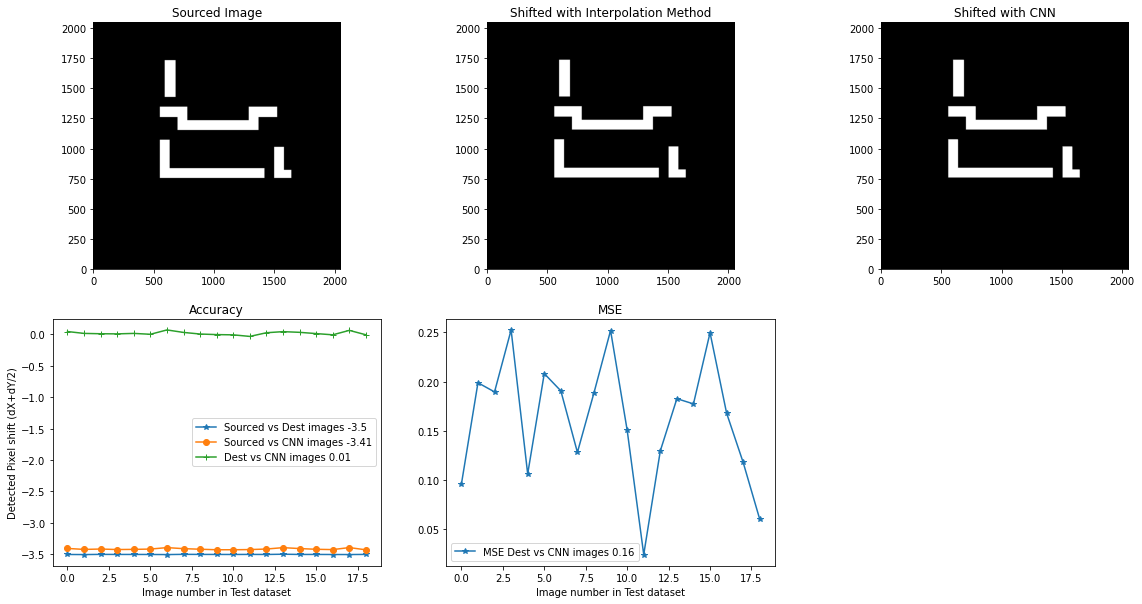

In [25]:
fig = plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(2,3,1)
ax0.set_title(f"Sourced Image")
ax1 = fig.add_subplot(2,3,2)
ax1.set_title(f"Shifted with Interpolation Method")
ax2 = fig.add_subplot(2,3,3)
ax2.set_title(f"Shifted with CNN")
ax3 = fig.add_subplot(2,3,4)
ax3.set_title(f"Accuracy")

ax4 = fig.add_subplot(2,3,5)
ax4.set_title(f"MSE")


src_image = cv2.imread('./output/1.png', cv2.COLOR_BGR2GRAY)
dst_image = cv2.imread('./output/s_1.png', cv2.COLOR_BGR2GRAY)
ml_image = cv2.imread('./output/ml_1.png', cv2.COLOR_BGR2GRAY)
ax0.imshow(src_image, origin='lower', cmap='gray')
ax1.imshow(dst_image, origin='lower', cmap='gray')
ax2.imshow(ml_image, origin='lower', cmap='gray')

ax3.plot(S0, '-*', label = f'Sourced vs Dest images {trunc(np.mean(S0),2)}')
ax3.plot(S1, '-o', label = f'Sourced vs CNN images {trunc(np.mean(S1),2)}')
ax3.plot(S2, '-+', label = f'Dest vs CNN images {trunc(np.mean(S2),2)}')
ax3.set_ylabel('Detected Pixel shift (dX+dY/2)')
ax3.set_xlabel('Image number in Test dataset')
ax3.legend()
ax4.plot(l, MSE, '-*',label = f'MSE Dest vs CNN images {trunc(np.mean(MSE),2)}')
ax4.set_xlabel('Image number in Test dataset')

ax4.legend()

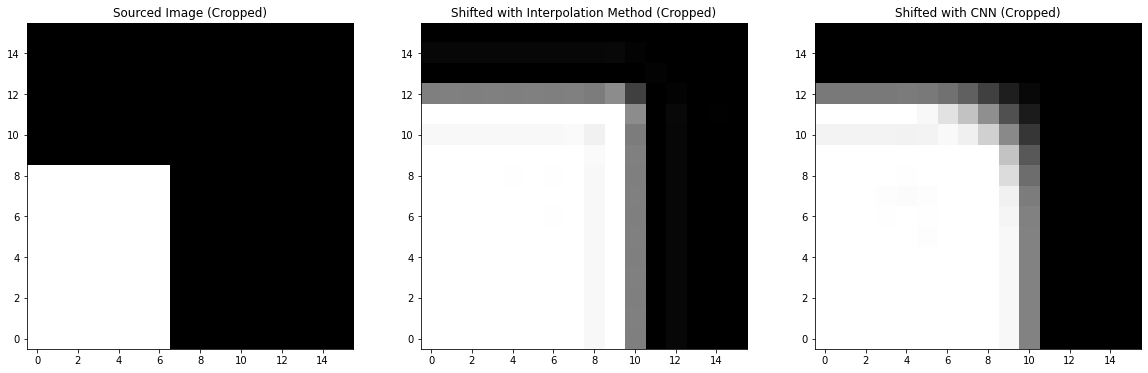

In [27]:
fig = plt.figure(figsize=(20, 6))

ax0 = fig.add_subplot(1,3,1)
ax0.set_title(f"Sourced Image (Cropped)")
ax1 = fig.add_subplot(1,3,2)
ax1.set_title(f"Shifted with Interpolation Method (Cropped)")
ax2 = fig.add_subplot(1,3,3)
ax2.set_title(f"Shifted with CNN (Cropped)")

x, y, h, w  = 1570, 1000, 16, 16
ax0.imshow(src_image[y:y+h, x:x+w], origin='lower', cmap='gray')
ax1.imshow(dst_image[y:y+h, x:x+w], origin='lower', cmap='gray')
ax2.imshow(ml_image[y:y+h, x:x+w], origin='lower', cmap='gray')